# Lab 6 Report
## Stock Prediction AI with Encoder-Decoder RNN

### Name: Owen Zhang

In [1047]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import seaborn as sns

In [1048]:
from IPython.display import Image # For displaying images in colab jupyter cell

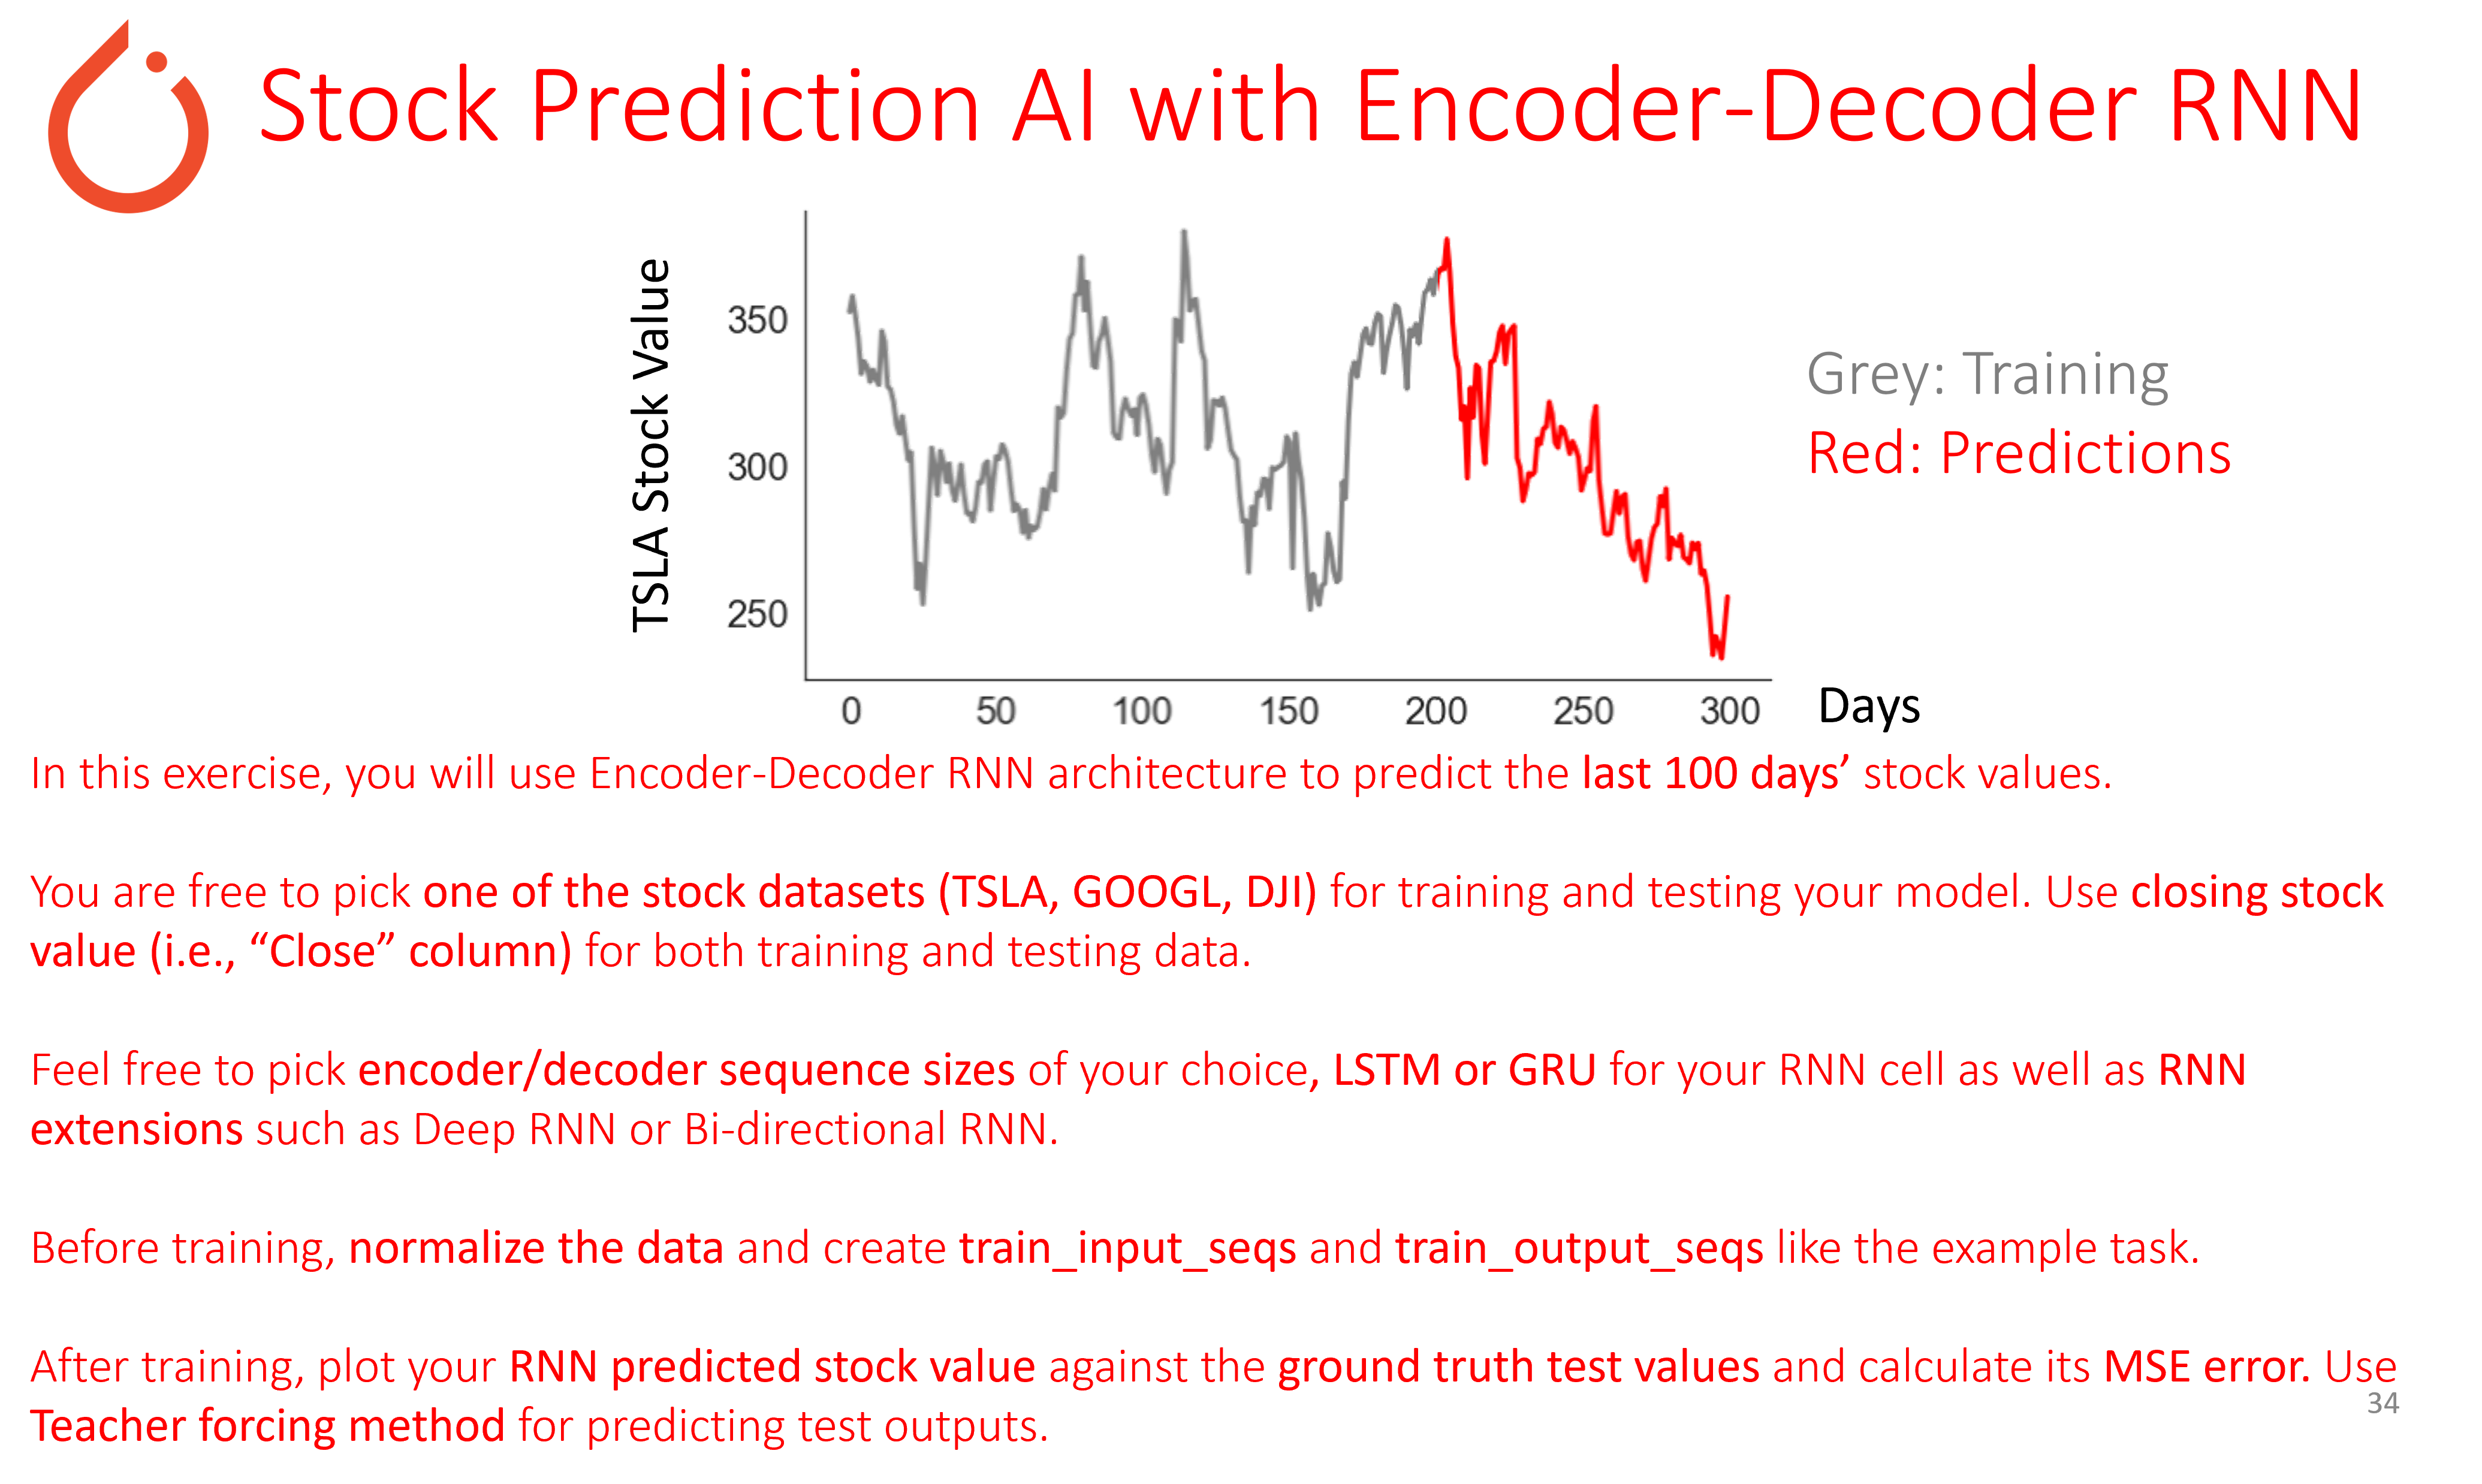

In [1049]:
Image('lab6_exercise.png', width = 1000)

In [1050]:
# Seaborn plot styling
sns.set(style = 'white', font_scale = 2)

## Prepare Data

In [1051]:
# Load stock datasets
# Pick one of three to train your model 
# Use 'closing price' column for training and testing

tesla = pd.read_csv('TSLA.csv') 
tesla_np = tesla.to_numpy()

google = pd.read_csv('GOOGL.csv') 
google_np = google.to_numpy()

dji = pd.read_csv('DJI.csv') 
dji_np = dji.to_numpy()

[-1.34637791 -1.34715544 -1.34733752 ...  2.77706963  2.75699962
  2.7893409 ]


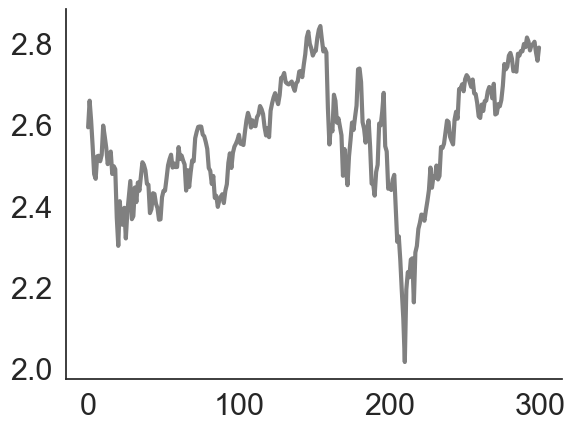

In [1052]:
# Normalize your data and select training dataset (all the days except for last 100 days)

# YOUR CODE HERE

def scale_data(arr):
    scaled = np.zeros(arr.shape)
    std = arr.std(axis = 0)
    mean = arr.mean(axis = 0)
    for i in range(np.size(arr, 0)):
        scaled[i] = (arr[i] - mean)/(std)

    return scaled

data = scale_data(np.array(dji_np[:, -3]))
print(data)


plt.plot(data[-300:], linewidth = 3, color = 'grey')
sns.despine()

In [1053]:
# Define your encoder input sequence length, decoder output sequence length and testing sequence length
# Construct train_input_seqs and train_output_seqs according to 
# encoder input sequence length and decoder output sequence length similar to example task

# YOUR CODE HERE

def generate_input_output_seqs(y, encoder_inputseq_len, decoder_outputseq_len, stride = 1, num_features = 1):
  
    L = y.shape[0] # Length of y
    
    # Calculate how many input/target sequences there will be based on the parameters and stride
    num_samples = (L - encoder_inputseq_len - decoder_outputseq_len) // stride + 1
    
    # Numpy zeros arrray to contain the input/target sequences
    # Note that they should be in (num_samples, seq_len, num_features/time step) format
    train_input_seqs = np.zeros([num_samples, encoder_inputseq_len, num_features])
    train_output_seqs = np.zeros([num_samples, decoder_outputseq_len, num_features])    
    
    # Iteratively fill in train_input_seqs and train_output_seqs
    # See slide 17 of lab 7 to get an idea of how input_seqs and output_seqs look like
    for ff in np.arange(num_features):
        
        for ii in np.arange(num_samples):
            
            start_x = stride * ii
            end_x = start_x + encoder_inputseq_len
            train_input_seqs[ii, :, ff] = y[start_x:end_x, ff]

            start_y = stride * ii + encoder_inputseq_len
            end_y = start_y + decoder_outputseq_len 
            train_output_seqs[ii, :, ff] = y[start_y:end_y, ff]

    return train_input_seqs, train_output_seqs



Encoder Training Inputs Shape:  (8524, 10, 1)
Decoder Training Outputs Shape:  (8524, 3, 1)


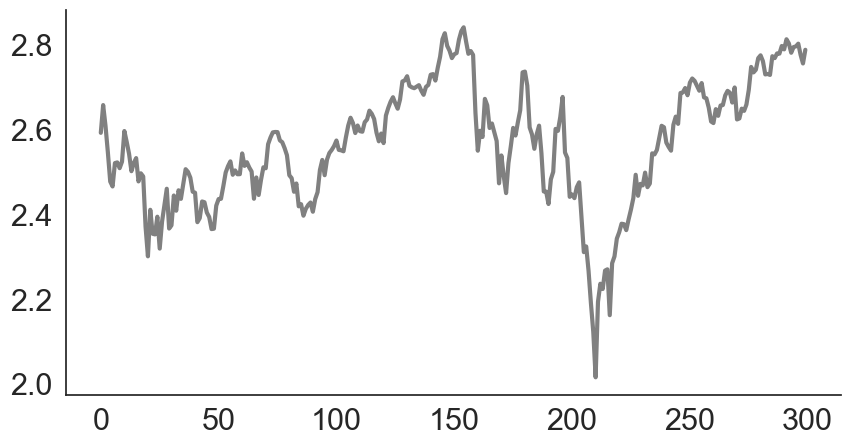

In [1054]:
# Make sure train_input_seqs and train_output_seqs have correct dimensions as expected
# (sample size, sequence length, # of features / timestep)
encoder_inputseq_len = 10
decoder_outputseq_len = 3
testing_sequence_len = 100

input_data = []
for i in data:
    input_data.append([i])
input_data = np.array(input_data)


train_input_seqs, train_output_seqs = generate_input_output_seqs(y = input_data[:-100],
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 1)
test_input_seqs, test_output_seqs = generate_input_output_seqs(y = input_data[-100:],
                                                                 encoder_inputseq_len = encoder_inputseq_len,
                                                                 decoder_outputseq_len = decoder_outputseq_len,
                                                                 stride = 1,
                                                                 num_features = 1)


plt.figure(figsize = (10, 5))

plt.plot(input_data[-300:], linewidth = 3, color = 'grey')
sns.despine()

print("Encoder Training Inputs Shape: ", train_input_seqs.shape)
print("Decoder Training Outputs Shape: ", train_output_seqs.shape)

## Define Model

In [1055]:
class Encoder(torch.nn.Module):

    def __init__(self, input_size, hidden_size, num_layers):
        
        super(Encoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers, 
                                  batch_first = True)
        
    def forward(self, input_seq, hidden_state):
        
        out, hidden = self.lstm(input_seq, hidden_state)
        
        return out, hidden     

class Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        
        super(Decoder, self).__init__()

        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, 
                                  num_layers = num_layers,
                                  batch_first = True)
        
        self.fc_decoder = torch.nn.Linear(hidden_size, output_size) 

    def forward(self, input_seq, encoder_hidden_states):
        
        lstm_out, hidden = self.lstm(input_seq, encoder_hidden_states)
        out = self.fc_decoder(lstm_out)   
        
        return out, hidden

class Encoder_Decoder(torch.nn.Module):
    
    def __init__(self, input_size, hidden_size, decoder_output_size, num_layers):

        super(Encoder_Decoder, self).__init__()

        self.Encoder = Encoder(input_size = input_size, hidden_size = hidden_size, 
                               num_layers = num_layers)
        
        self.Decoder = Decoder(input_size = input_size, hidden_size = hidden_size, 
                               output_size = decoder_output_size, num_layers = num_layers)

## Define Hyperparameters

In [1056]:
torch.manual_seed(2)

Encoder_Decoder_RNN = Encoder_Decoder(input_size = 1, hidden_size = 15, 
                                      decoder_output_size = 1, num_layers = 1)

learning_rate = 0.005
epochs = 100

batchsize = 100
num_features = train_output_seqs.shape[2]

print(num_features)
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Encoder_Decoder_RNN.parameters(), lr=learning_rate)

Encoder_Decoder_RNN

1


Encoder_Decoder(
  (Encoder): Encoder(
    (lstm): LSTM(1, 15, batch_first=True)
  )
  (Decoder): Decoder(
    (lstm): LSTM(1, 15, batch_first=True)
    (fc_decoder): Linear(in_features=15, out_features=1, bias=True)
  )
)

## Identify Tracked Values

In [1057]:
train_loss_list = []

## Train Model

In [1058]:
# Convert training data into torch tensors

train_input_seqs = torch.from_numpy(train_input_seqs).float()
train_output_seqs = torch.from_numpy(train_output_seqs).float()

# Split training data into mini-batches
train_batches_features = torch.split(train_input_seqs, batchsize)[:-1]
train_batches_targets = torch.split(train_output_seqs, batchsize)[:-1]

# Compute total number of mini-batches in training data

batch_split_num = len(train_batches_features)

In [1059]:
for epoch in range(epochs): 
    
    for k in range(batch_split_num): 
        
        hidden_state = None
        decoder_output_seq = torch.zeros(batchsize, decoder_outputseq_len, num_features)
        optimizer.zero_grad()
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(train_batches_features[k], hidden_state)
        decoder_hidden = encoder_hidden
        
        decoder_input = train_batches_features[k][:, -1, :]
        decoder_input = torch.unsqueeze(decoder_input, 2)
        
        for t in range(decoder_outputseq_len):
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            decoder_output_seq[:, t,:] = torch.squeeze(decoder_output, 2)
            decoder_input= train_batches_targets[k][:, t, :]
            decoder_input = torch.unsqueeze(decoder_input, 2)
            
        loss = loss_func(torch.squeeze(decoder_output_seq), torch.squeeze(train_batches_targets[k]))
        train_loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    
    print("Averaged Training Loss for Epoch", epoch,": ", np.mean(train_loss_list[-batch_split_num:]))

Averaged Training Loss for Epoch 0 :  0.3030669992022655
Averaged Training Loss for Epoch 1 :  0.5737532965818365
Averaged Training Loss for Epoch 2 :  0.19342114853891818
Averaged Training Loss for Epoch 3 :  0.043422068262417964
Averaged Training Loss for Epoch 4 :  0.03265318718485479
Averaged Training Loss for Epoch 5 :  0.014316131867920322
Averaged Training Loss for Epoch 6 :  0.009583400768101187
Averaged Training Loss for Epoch 7 :  0.006549129595377428
Averaged Training Loss for Epoch 8 :  0.0066243522283484174
Averaged Training Loss for Epoch 9 :  0.0060537250630338406
Averaged Training Loss for Epoch 10 :  0.005864409627803766
Averaged Training Loss for Epoch 11 :  0.007533741442089462
Averaged Training Loss for Epoch 12 :  0.007856269135749352
Averaged Training Loss for Epoch 13 :  0.012875019743189435
Averaged Training Loss for Epoch 14 :  0.009454803079407771
Averaged Training Loss for Epoch 15 :  0.012267917207688751
Averaged Training Loss for Epoch 16 :  0.0057298913794

## Visualize & Evaluate Model

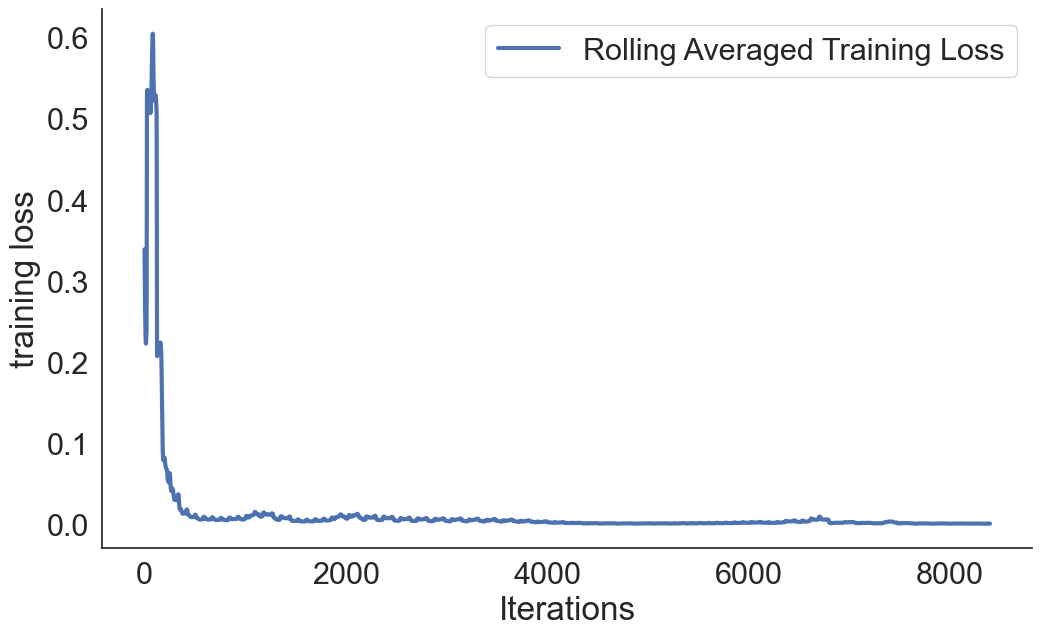

In [1060]:
plt.figure(figsize = (12, 7))

plt.plot(np.convolve(train_loss_list, np.ones(100), 'valid') / 100, 
         linewidth = 3, label = 'Rolling Averaged Training Loss')
plt.ylabel("training loss")
plt.xlabel("Iterations")
plt.legend()
sns.despine()

In [1061]:
# Define your testing sequence

test_input_seq = input_data[-100:]
print(test_input_seq)

[[2.44786978]
 [2.43917269]
 [2.46493108]
 [2.47643183]
 [2.3949273 ]
 [2.31167444]
 [2.32523365]
 [2.26749633]
 [2.19137389]
 [2.12342536]
 [2.01628226]
 [2.1944659 ]
 [2.23717602]
 [2.22464044]
 [2.26811979]
 [2.27120027]
 [2.16293359]
 [2.28545823]
 [2.30156479]
 [2.34357423]
 [2.35861136]
 [2.37875506]
 [2.37777565]
 [2.36365065]
 [2.38919919]
 [2.41242176]
 [2.43914962]
 [2.49430658]
 [2.44478931]
 [2.47286214]
 [2.4691912 ]
 [2.49936702]
 [2.46508711]
 [2.47357435]
 [2.54491316]
 [2.54242155]
 [2.55295603]
 [2.58174075]
 [2.60997953]
 [2.6064989 ]
 [2.57028453]
 [2.55991761]
 [2.55118752]
 [2.61231544]
 [2.63159122]
 [2.61455138]
 [2.68736011]
 [2.68868393]
 [2.69903771]
 [2.68200941]
 [2.71172932]
 [2.72159421]
 [2.71602212]
 [2.704077  ]
 [2.69273228]
 [2.71082873]
 [2.67692751]
 [2.67479185]
 [2.65294724]
 [2.62010232]
 [2.61633111]
 [2.64924331]
 [2.63345969]
 [2.65777476]
 [2.65893102]
 [2.68172043]
 [2.69242054]
 [2.68803772]
 [2.66479208]
 [2.70036153]
 [2.62487409]
 [2.62

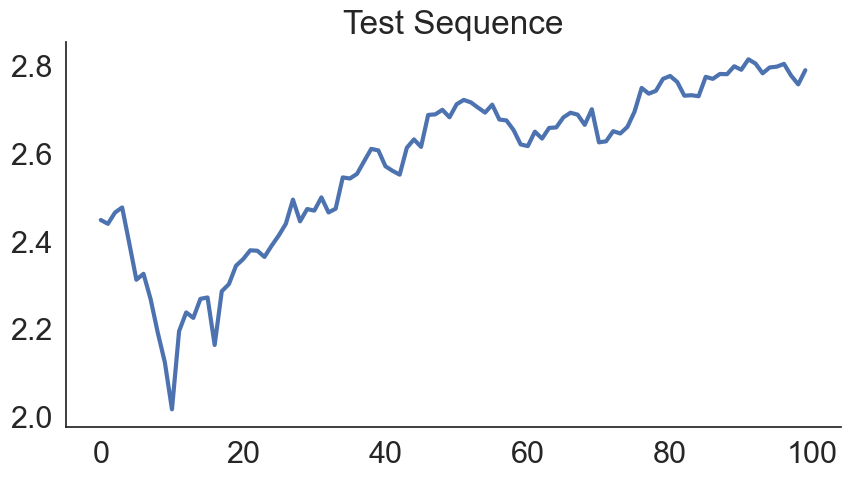

In [1062]:
# We can visualize the testing sequence

plt.figure(figsize = (10, 5))
plt.plot(test_input_seq, linewidth = 3)
plt.title('Test Sequence')
sns.despine()

### Generate signal predictions for testing sequence with trained Encoder-Decoder

In [1063]:
# USE TEACHER FORCING METHOD WHEN GENERATING OUTPUTS FROM DECODER
# See slide 42 of Lab 5 or Lab 5 part 2 video to recap the concept of teacher forcing method
# When generating decoder outputs, make sure each input to decoder at timestep t has the shape (1,1,1)
# i.e., num_samples = 1, sequence_len = 1, num_features = 1 
test_input_seq = torch.from_numpy(test_input_seq).float()

# initialize empty torch tensor array to store decoder output sequence
# This should be the same size as the test sequence
decoder_output_seq = torch.zeros(testing_sequence_len, num_features)

# First n-datapoints in decoder output sequence = First n-datapoints in ground truth test sequence
# n = encoder_input_seq_len
decoder_output_seq[:encoder_inputseq_len] = test_input_seq[:encoder_inputseq_len]

# Initialize index for prediction
pred_start_ind = 0

# Activate no_grad() since we aren't performing backprop
with torch.no_grad():
    
    # Loop continues until the RNN prediction reaches the end of the testing sequence length
    while pred_start_ind + encoder_inputseq_len + decoder_outputseq_len < testing_sequence_len:
        
        # initialize hidden state for encoder
        hidden_state = None
        
        # Define the input to encoder
        input_test_seq = decoder_output_seq[pred_start_ind:pred_start_ind + encoder_inputseq_len]
        # Add dimension to first dimension to keep the input (sample_size, seq_len, # of features/timestep)
        input_test_seq = torch.unsqueeze(input_test_seq, 0)
        
        # Feed the input to encoder and set resulting hidden states as input hidden states to decoder
        encoder_output, encoder_hidden = Encoder_Decoder_RNN.Encoder(input_test_seq, hidden_state)
        decoder_hidden = encoder_hidden
        # Initial input to decoder is last timestep feature from the encoder input sequence 
        decoder_input = test_input_seq[pred_start_ind][0]
        # Add dimension to keep the input (sample_size, seq_len, # of features/timestep)
        decoder_input = torch.unsqueeze(decoder_input, 0)
        decoder_input = torch.unsqueeze(decoder_input, 0)
        decoder_input = torch.unsqueeze(decoder_input, 0)
        # Populate decoder output sequence
        for t in range(decoder_outputseq_len):
            
            # Generate new output for timestep t
            decoder_output, decoder_hidden = Encoder_Decoder_RNN.Decoder(decoder_input, decoder_hidden)
            # Populate the corresponding timestep in decoder output sequence
            decoder_output_seq[pred_start_ind + encoder_inputseq_len + t] = torch.squeeze(decoder_output)
            # Use the output of the decoder as new input for the next timestep
            decoder_input = decoder_output
        
        # Update pred_start_ind
        pred_start_ind += decoder_outputseq_len


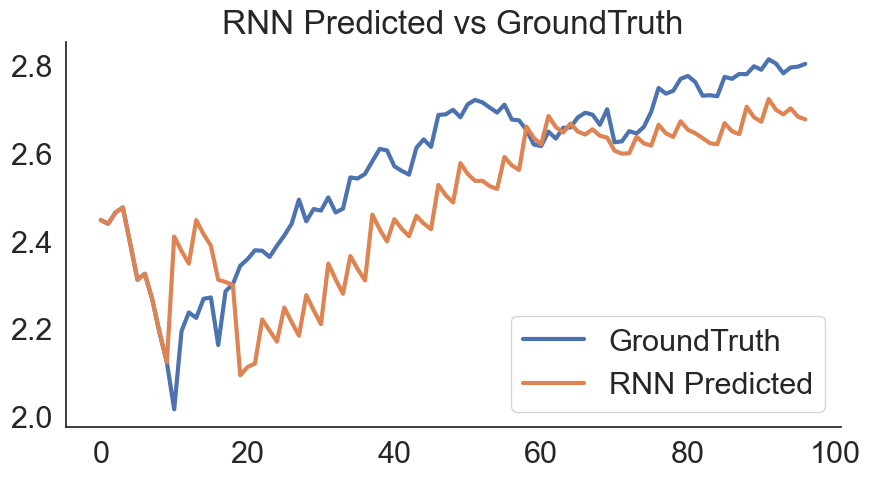

In [1064]:
# Visualize predicted stock sequence vs the ground truth
test_input_seq = test_input_seq[:-decoder_outputseq_len]
decoder_output_seq = decoder_output_seq[:-decoder_outputseq_len]
plt.figure(figsize = (10, 5))

plt.plot(test_input_seq, linewidth = 3, label = 'GroundTruth')
plt.plot(decoder_output_seq, linewidth = 3, label = 'RNN Predicted')
plt.title('RNN Predicted vs GroundTruth')
plt.legend()
sns.despine()

In [1065]:
# Compute the MSE error between test_input_seq and decoder_output_seq and print the value as Test MSE Error

# YOUR CODE HERE
print(loss_func(torch.squeeze(test_input_seq), torch.squeeze(decoder_output_seq)).numpy())

0.020078823
